In [1]:
import numpy as np
import pandas as pd

folderpath = "./data/ATC/"
filename = "atc-20121114.csv"
chunksize = 1_000_000

atc_header_names = [
    "time [ms]",
    "person id",
    "position x [mm]",
    "position y [mm]",
    "position z (height) [mm]",
    "velocity [mm/s]",
    "angle of motion [rad]",
    "facing angle [rad]"
]

TIME_COL = "time [ms]"
PID_COL  = "person id"

KEEP_COLS = [
    "position x [mm]",
    "position y [mm]",
    "velocity [mm/s]",
    "angle of motion [rad]",
    "facing angle [rad]",
]

In [ ]:
def filter_people_with_trajectories_ge_10s(folderpath, filename, chunksize=500_000, min_s=10, atc_header_names=None):
    path = f"{folderpath}/{filename}"

    tmin = {}
    tmax = {}

    it1 = pd.read_csv(path, chunksize=chunksize, header=None, names=atc_header_names)
    for chunk in it1:
        chunk["time [ms]"] = pd.to_numeric(chunk["time [ms]"], errors="coerce")
        chunk = chunk.dropna(subset=["time [ms]", "person id"])

        g = chunk.groupby("person id")["time [ms]"].agg(["min", "max"])

        for pid, row in g.iterrows():
            mn, mx = float(row["min"]), float(row["max"])
            if pid not in tmin:
                tmin[pid], tmax[pid] = mn, mx
            else:
                if mn < tmin[pid]:
                    tmin[pid] = mn
                if mx > tmax[pid]:
                    tmax[pid] = mx

    qualifying_ids = {pid for pid in tmin if (tmax[pid] - tmin[pid]) >= min_s}

    out_chunks = []
    it2 = pd.read_csv(path, chunksize=chunksize, header=None, names=atc_header_names)
    for chunk in it2:
        chunk = chunk[chunk["person id"].isin(qualifying_ids)]
        if not chunk.empty:
            out_chunks.append(chunk)

    if out_chunks:
        result = pd.concat(out_chunks, ignore_index=True)
    else:
        result = pd.DataFrame(columns=atc_header_names)

    return result, qualifying_ids

def make_nonoverlapping_48s_windows_wide(df: pd.DataFrame, window_s: int = 48) -> pd.DataFrame:
    d = df[[TIME_COL, PID_COL] + KEEP_COLS].copy()

    d["t_sec"] = np.floor(pd.to_numeric(d[TIME_COL], errors="coerce")).astype("Int64")
    d = d.dropna(subset=["t_sec", PID_COL]).copy()

    per_sec = (
        d.groupby([PID_COL, "t_sec"], as_index=False)[KEEP_COLS]
         .mean()
         .sort_values([PID_COL, "t_sec"])
    )

    per_sec["prev_t"] = per_sec.groupby(PID_COL)["t33_sec"].shift(1)
    per_sec["new_run"] = (per_sec["prev_t"].isna()) | ((per_sec["t_sec"] - per_sec["prev_t"]) != 1)
    per_sec["run_id"] = per_sec.groupby(PID_COL)["new_run"].cumsum()

    per_sec["pos_in_run"] = per_sec.groupby([PID_COL, "run_id"]).cumcount()
    per_sec["win_in_run"] = (per_sec["pos_in_run"] // window_s).astype(int)
    per_sec["pos_in_win"] = (per_sec["pos_in_run"] % window_s).astype(int)

    win_sizes = per_sec.groupby([PID_COL, "run_id", "win_in_run"])["pos_in_win"].transform("size")
    per_sec = per_sec[win_sizes >= window_s].copy()

    long = per_sec.melt(
        id_vars=[PID_COL, "run_id", "win_in_run", "pos_in_win", "t_sec"],
        value_vars=KEEP_COLS,
        var_name="feature",
        value_name="value",
    )

    feature_map = {
        "position x [mm]": "position_x",
        "position y [mm]": "position_y",
        "velocity [mm/s]": "velocity",
        "angle of motion [rad]": "angle_of_motion",
        "facing angle [rad]": "facing_angle",
    }
    long["feature"] = long["feature"].map(feature_map)
    long["col"] = long["feature"] + "_" + long["pos_in_win"].astype(str)

    wide = (
        long.pivot_table(
            index=[PID_COL, "run_id", "win_in_run"],
            columns="col",
            values="value",
            aggfunc="first",
        )
        .reset_index()
    )

    start_t = (
        per_sec.groupby([PID_COL, "run_id", "win_in_run"], as_index=False)["t_sec"]
              .min()
              .rename(columns={"t_sec": "start_t_sec"})
    )
    wide = wide.merge(start_t, on=[PID_COL, "run_id", "win_in_run"], how="left")

    ordered_cols = ["index", "person_id"]
    wide = wide.rename(columns={PID_COL: "person_id"})

    id_cols = ["person_id", "run_id", "win_in_run", "start_t_sec"]
    feat_cols = [c for c in wide.columns if c not in id_cols]

    def _key(c):
        stem, k = c.rsplit("_", 1)
        return (stem, int(k))
    feat_cols = sorted(feat_cols, key=_key)
    wide = wide[id_cols + feat_cols]

    wide.insert(0, "index", np.arange(len(wide), dtype=int))

    return wide

In [3]:
data, _ = filter_people_with_trajectories_ge_10s(
    folderpath=folderpath,
    filename=filename,
    chunksize=1_000_000,
    min_s=48,
    atc_header_names=atc_header_names
)
wide_df = make_nonoverlapping_48s_windows_wide(data, window_s=48)
person_ids = data['person id'].unique().tolist()
positions = wide_df.loc[:, wide_df.columns.str.contains('position_')]

KeyboardInterrupt: 

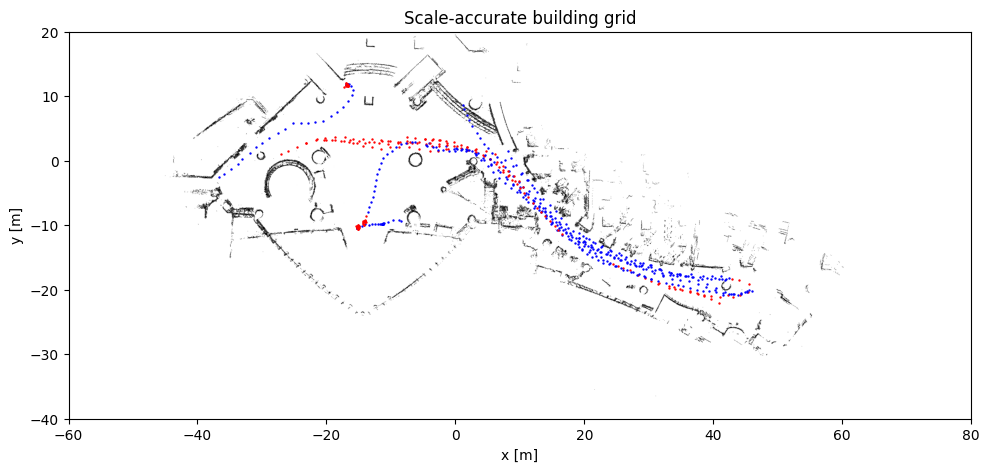

In [ ]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

yaml_path = f"{folderpath}/ATC-map/localization_grid.yaml"

with open(yaml_path, "r") as f:
    meta = yaml.safe_load(f)

img_path = meta["image"]
res = float(meta["resolution"])
origin_x, origin_y, origin_yaw = meta["origin"]

img = mpimg.imread(f"{folderpath}/ATC-map/{img_path}")

img = np.array(img)
if img.ndim == 3:
    img = img[..., 0]

h, w = img.shape

x0 = origin_x
y0 = origin_y
x1 = origin_x + w * res
y1 = origin_y + h * res

fig, ax = plt.subplots(figsize=(10, 8))

ax.imshow(img, cmap="gray", extent=[x0, x1, y0, y1])

ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Scale-accurate building grid")

for idx, position in positions.iterrows():
    plt.scatter(position[:32] / a, position[48:80] / 1000, s=0.5, c='blue')
    plt.scatter(position[32:48] / 1000, position[80:] / 1000, s=0.5, c='red')
    if idx > 10:
        break

plt.tight_layout()
plt.show()

In [2]:
import torch
import tqdm

dimension_size = 2
dataset_size = 10**5
batch_size = 64
time_batch_size = 64

source_1 = torch.rand(
    size=(dataset_size // 2, dimension_size)
) + 2
source_2 = torch.rand(
    size=(dataset_size // 2, dimension_size)
) + 2

def calculate_log_likelihood(tensor: torch.Tensor):
    return (-1/2)*tensor.norm(dim=-1, keepdim=True).pow(2)

def calculate_divergence_gpt(f, y):
    """
    Computes the divergence of vector field f w.r.t. y.
    f: Tensor of shape (..., d) representing the vector field.
    y: Tensor of shape (..., d) representing coordinates (x, y, z...).
    """
    divergence = 0
    for i in range(f.shape[-1]):
        grad = torch.autograd.grad(f[..., i], y, torch.ones_like(f[..., i]), create_graph=True)[0]
        divergence += grad[..., i]
    return divergence

def divergence_hutchinson(f, x, n_samples=1):
    div = 0.0
    for _ in range(n_samples):
        v = torch.randn_like(x)
        jvp = torch.autograd.grad(
            f, x, v, create_graph=True
        )[0]
        div += (jvp * v).sum(dim=-1)
    return div / n_samples

class VelocityField(torch.nn.Module):
    def __init__(self, dimension_size):
        super().__init__()
        self.potential_network = torch.nn.Sequential(
            torch.nn.Linear(dimension_size, 8),
            torch.nn.Softplus(),
            torch.nn.Linear(8, 1),
        )

    def forward(self, tensor: torch.Tensor):
        potential = self.potential_network(tensor)
        return torch.autograd.grad(
            potential.sum(), tensor, create_graph=True,
        )[0]

# velocity_model = VelocityField(dimension_size=dimension_size)
velocity_model = torch.nn.Sequential(
    torch.nn.Linear(dimension_size, 256),
    torch.nn.Softplus(),
    torch.nn.Linear(256, dimension_size),
)
dataset = torch.utils.data.TensorDataset(source_1, source_2)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(velocity_model.parameters())

In [7]:
progress_bar = tqdm.trange(10)

for epoch in progress_bar:
    for (source_batch_for_divergence_loss, _) in dataloader:
        optimizer.zero_grad()
        # source_batch_for_divergence_loss = source_batch_for_divergence_loss.requires_grad_(True)
        # elementwise_divergence = calculate_divergence_gpt(
        #     source_batch_for_divergence_loss + 0.5 * velocity_model(source_batch_for_divergence_loss),
        #     source_batch_for_divergence_loss
        # )
        # divergence_loss = -elementwise_divergence.mean()
        divergence_loss = 0
        
        elementwise_log_likelihood = calculate_log_likelihood(source_batch_for_divergence_loss + velocity_model(source_batch_for_divergence_loss))
        log_likelihood_loss = -elementwise_log_likelihood.mean()
        
        total_loss = divergence_loss + log_likelihood_loss
        total_loss.backward()

        optimizer.step()

        progress_bar.set_postfix({
            "loss":total_loss.item()
        })

100%|██████████| 10/10 [00:05<00:00,  1.68it/s, loss=5.72e-5]


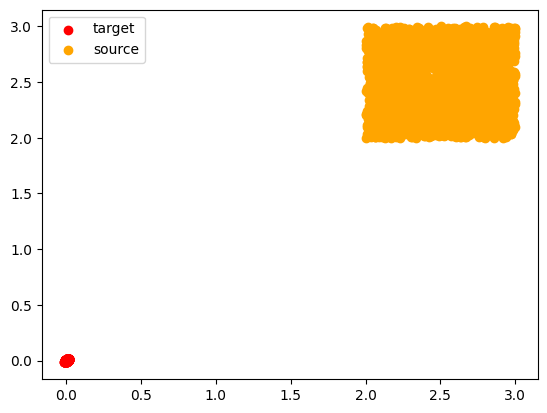

In [8]:
import matplotlib.pyplot as plt
test_batch_size = 2064

test_batch = torch.rand(test_batch_size, dimension_size) + 2
test_batch = test_batch.requires_grad_(True)
test_samples = test_batch + velocity_model(test_batch)

test_batch_numpy = test_batch.detach().numpy()
test_samples_numpy = test_samples.detach().numpy()

plt.scatter(test_samples_numpy[:, 0], test_samples_numpy[:, 1], color="red", label="target")
plt.scatter(test_batch_numpy[:, 0], test_batch_numpy[:, 1], color="orange", label="source")
plt.legend()
plt.show()

In [17]:
import numpy as np

# Generic quantile-map sampler: X = Q(U)
def quantile_map(Q, n, rng=None):
    """
    Draw n samples via quantile transform.
    Q: callable quantile function, Q(u) for u in (0,1)
    """
    rng = np.random.default_rng(rng)
    u = rng.random(n)              # U ~ Unif(0,1)
    x = Q(u)                       # X = Q(U)
    return u, x

# Example 1: Exponential(lambda) using Q(u) = -log(1-u)/lambda
lam = 1.0
Q_exp = lambda u: -np.log1p(-u) / lam
u, x_exp = quantile_map(Q_exp, n=10_000, rng=0)

# Example 2: Logistic(mu, s) using Q(u) = mu + s*log(u/(1-u))
mu, s = 0.0, 1.0
Q_logistic = lambda u: mu + s * np.log(u / (1.0 - u))
u, x_logistic = quantile_map(Q_logistic, n=10_000, rng=0)

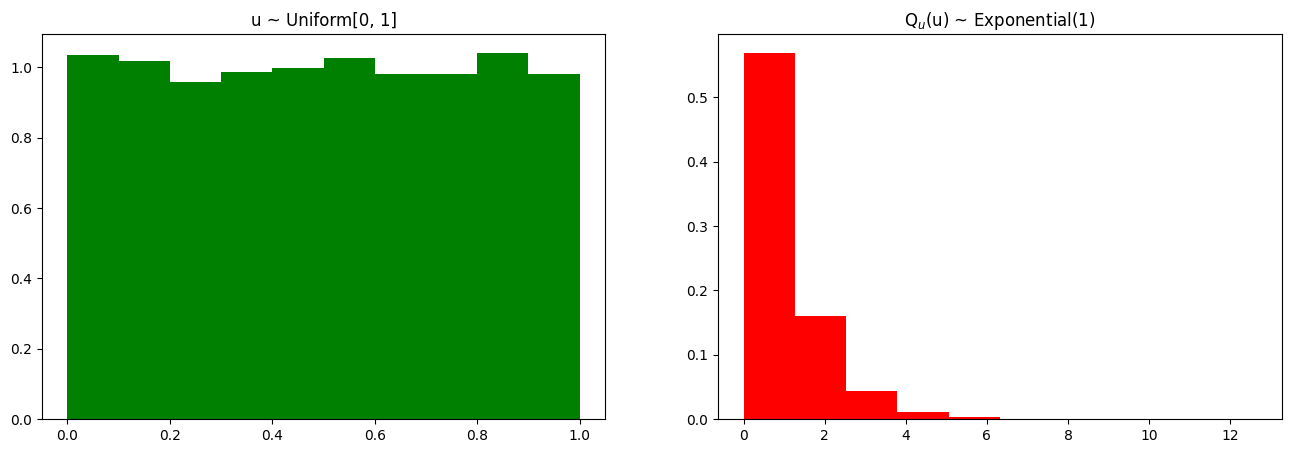

In [ ]:
import matplotlib.pyplot as plt

# Generic quantile-map sampler: X = Q(U)
def quantile_map(Q, n, rng=None):
    """
    Draw n samples via quantile transform.
    Q: callable quantile function, Q(u) for u in (0,1)
    """
    rng = np.random.default_rng(rng)
    u = rng.random(n)              # U ~ Unif(0,1)
    x = Q(u)                       # X = Q(U)
    return u, x

lam = 1.0
Q_exp = lambda u: -np.log1p(-u) / lam
u, x_exp = quantile_map(Q_exp, n=10_000, rng=0)

figure = plt.figure(figsize=(16, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(u, density=True, color='green')
ax1.set_title("u ~ Uniform[0, 1]")

ax2 = plt.subplot(1, 2, 2)
ax2.hist(x_exp, density=True, color='red')
ax2.set_title("Q$_u$(u) ~ Exponential(1)")
plt.show()

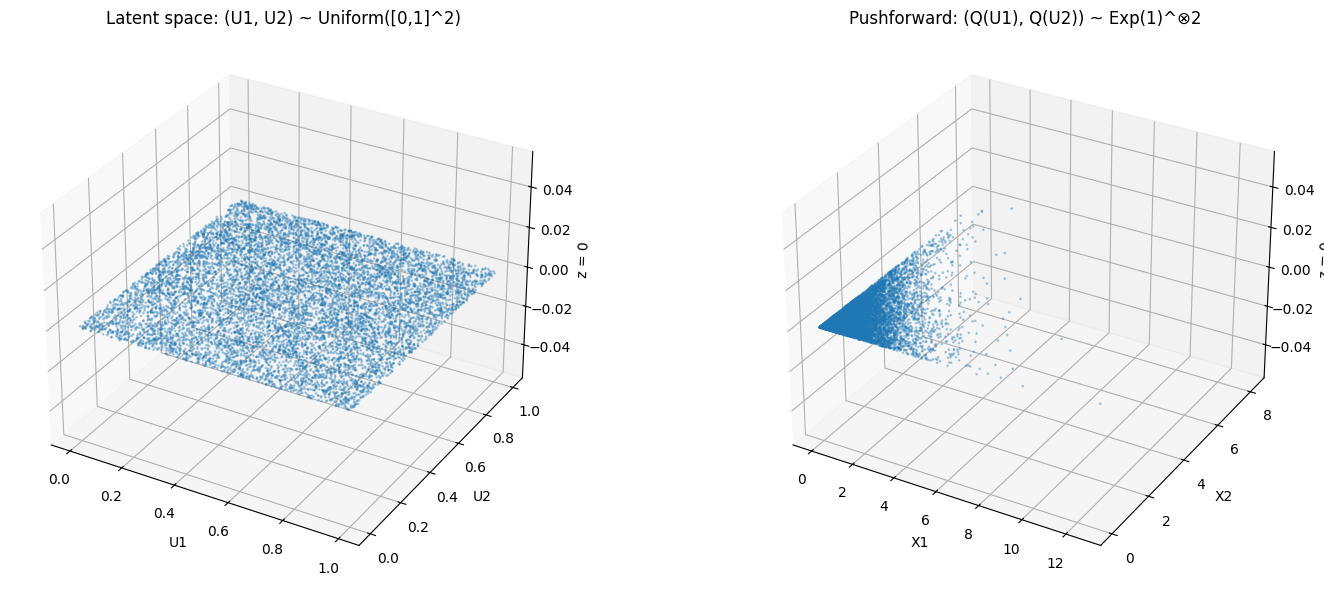

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Quantile map
lam = 1.0
Q_exp = lambda u: -np.log1p(-u) / lam

# Sample latent variables
rng = np.random.default_rng(0)
n = 10_000
u = rng.random((n, 2))        # (U1, U2) ~ Unif([0,1]^2)
x = Q_exp(u)                  # (X1, X2) coordinate-wise map

# 3D visualization
fig = plt.figure(figsize=(16, 6))

# Latent space
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(u[:, 0], u[:, 1], np.zeros(n), s=1, alpha=0.3)
ax1.set_title("Latent space: (U1, U2) ~ Uniform([0,1]^2)")
ax1.set_xlabel("U1")
ax1.set_ylabel("U2")
ax1.set_zlabel("z = 0")

# Transformed space
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x[:, 0], x[:, 1], np.zeros(n), s=1, alpha=0.3)
ax2.set_title("Pushforward: (Q(U1), Q(U2)) ~ Exp(1)^⊗2")
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("z = 0")

plt.tight_layout()
plt.show()

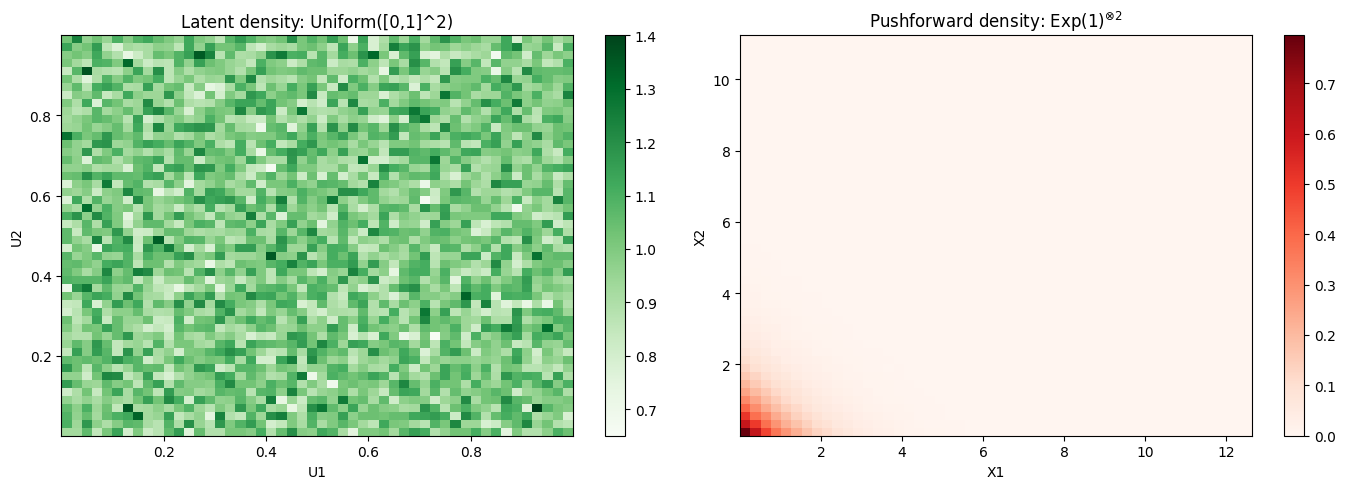

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Quantile map
lam = 1.0
Q_exp = lambda u: -np.log1p(-u) / lam

# Sample
rng = np.random.default_rng(0)
n = 200_000
u = rng.random((n, 2))   # (U1, U2) ~ Unif([0,1]^2)
x = Q_exp(u)             # coordinate-wise quantile map

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latent 2D histogram
h1 = axes[0].hist2d(
    u[:, 0], u[:, 1],
    bins=50,
    density=True,
    cmap="Greens"
)
axes[0].set_title("Latent density: Uniform([0,1]^2)")
axes[0].set_xlabel("U1")
axes[0].set_ylabel("U2")
plt.colorbar(h1[3], ax=axes[0])

# Transformed 2D histogram
h2 = axes[1].hist2d(
    x[:, 0], x[:, 1],
    bins=50,
    density=True,
    cmap="Reds"
)
axes[1].set_title("Pushforward density: Exp(1)$^{\\otimes 2}$")
axes[1].set_xlabel("X1")
axes[1].set_ylabel("X2")
plt.colorbar(h2[3], ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
pushforward = ...
dataset = ...
dataloader = ...
pushforward.fit(...)

pushforward.push_u_given_x
pushforward.push_y_given_y

conformal_predictor = conformal_predictor(pushforward)
conformal_predictor.fit(...)

conformal_predictor.calculate_volume(...)
conformal_predictor.